# Welcome to the Competition


Teams member:
yuchunsing1@gmail.com -- Chun Sing Yu
zacarysun@gmail.com -- Zacary Sun

## Introduction

* Water is one of the most valueable ressources not only to our humans but for many other living organisms as well. 

* In this competition we will focus only on the water sector to help Acea Group preserve precious waterbodies. As it is easy to imagine, a water supply company struggles with the need to forecast the water level in a waterbody (water spring, lake, river, or aquifer) to handle daily consumption. During fall and winter waterbodies are refilled, but during spring and summer they start to drain. 
* To help preserve the health of these waterbodies it is important to predict the most efficient water availability, in terms of level and water flow for each day of the year.

## Data Overview

* Since Acea Groups is an Italian multiutility operator, we are looking at datasets containing information about **waterbodies in Italy**. The Acea Group deals with four different type of waterbodies: 
    1. water springs
    2. lakes
    3. rivers 
    4. aquifers.
* Each waterbody has such unique characteristics that their attributes are not linked to each other. This analytics competition uses datasets that are completely independent from each other. However, it is critical to understand total availability in order to preserve water across the country.

## Challenge
* The challenge is to determine **how features influence the water availability of each presented waterbody**. To be more straightforward, **gaining a better understanding of volumes**, they will be able to ensure water availability for each time interval of the year.

## Libraries we use

* **PyCaret** is an open-source, low-code machine learning library in Python that aims to reduce the cycle time from hypothesis to insights. It is well suited for seasoned data scientists who want to increase the productivity of their ML experiments by using PyCaret in their workflows or for citizen data scientists and those new to data science with little or no background in coding. PyCaret allows you to go from preparing your data to deploying your model within seconds using your choice of notebook environment. [(PyCaret)](https://pycaret.org)

In [ ]:
!pip install --upgrade pip --user
!pip install --upgrade seaborn --user
!pip install pycaret --user
!pip install termcolor --user
!pip install wget --user
!pip install geoplot --user


In [ ]:
#Package need in this project


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, date
# Missing Value
# -----------------------------------
# !pip install missingno
import missingno as msno

# Configuration
# -----------------------------------
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

from termcolor import colored


#sklearn Area
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from astropy.coordinates import Angle # some lat/lng are formatted weirdly
from astropy import units as u

EARTH_RADIUS = 3958.761 #in miles 

import geoplot
import geoplot.crs as gcrs
import geopandas as gpd

In [ ]:
#matplot 調整區
plt.rcParams['figure.dpi'] = 300

In [ ]:
#kaggle自帶區域
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

## Helper Functions we create

* **corr_plot(data,figsize = (10,6))**: It is used to show the correlation among different features.
* **vis(data)**: It is used to visualize the data of different features by lineplot.
* **time(data)**: It is used to transform the data type of 'Date' to datetime. In addition, it add two features of time: month and day.
* **takecolumn(data)**: It is used to extract the names of features with the same type, returned in the form of a list, such as rainfall, temperature, etc.
* **moreday(data,Columns,days,Dimension)**: It is used to create a lag term of a specific feature as a new feature.
* **season(data)**: It is used to generate seasonal variables as new features, these variables are all dummy variables. And the division of seasons is based on the Italian climate.
* **SNEnewcolumn(data,col,compnum,define)**: It is used to reduce dimensionality with the method of TSNE.
* **AVG(data, column, Dimension, define)**: It is used to generate the moving average value as new feature, and it can also reduce the new features' dimensionality

In [ ]:
##作圖封裝區##


#熱力圖
def corr_plot(data, figsize = (10, 6)):
    fig, ax = plt.subplots(figsize = figsize)
    plt.title('Correlations (Pearson)', size = 15, fontweight = 'bold', fontfamily = 'serif')
    
    mask = np.triu(np.ones_like(data.corr(), dtype = bool))
    sns.heatmap(round(data.corr(), 2), mask=mask,cmap = 'YlGnBu', annot = True,annot_kws={"size":6})
    plt.rcParams['figure.dpi'] = 300
    
    plt.show()
    
#???時好時不好     
def vis(data):
    list_col = data.columns.tolist()
    fig, ax = plt.subplots(nrows=len(list_col), ncols=1, figsize=(20,90))

    for i in range(len(list_col)):
        sns.lineplot(x=data.Date, y=(data.iloc[:,i]).fillna(np.inf), ax=ax[i], color='dodgerblue')
        ax[i].set_title(list_col[i], fontsize=14)
        ax[i].set_ylabel(ylabel=list_col[i], fontsize=14)
        
        ax[i].set_xlim(date(2010,1,1), date(2020,6,30))
        ax[i].grid(axis = 'y', linestyle = '--', alpha = 0.9)

#統一增加時間規格
def time(data):
    #從文字變成時間格式
    data['Date'] = data['Date'].apply(lambda x: datetime.strptime(x, "%d/%m/%Y"))
    y = data.iloc[0]['Date'].year
    #Lake_na['year-month'] = Lake_na['date'].apply(lambda x: int((x.year-y)*12+x.month))
    
    #月份加時間
    #data['month/day'] = data['Date'].apply(lambda x:str(x.month) + "/" + str(x.day))
    #Lake_na['year'] = Lake_na['date'].apply(lambda x: int(x.year))
    
    #月份
    data['month'] = data['Date'].apply(lambda x: int(x.month))
    #日
    data['day'] = data['Date'].apply(lambda x: int(x.day))
        


In [ ]:
#有時候方便取column
def takecolumn(data):
    col = data.columns.tolist()
    RainfallCol = []
    DepthCol = []
    TempCol = []
    VolCol = []
    HydroCol = []
    for i in col:
        if i.startswith('Rain'):
            RainfallCol.append(i.strip())
        elif i.startswith('Depth'):
            DepthCol.append(i.strip())
        elif i.startswith('Temp'):
            TempCol.append(i.strip())
        elif i.startswith('Vol'):
            VolCol.append(i.strip())
        elif i.startswith('Hydro'):
            HydroCol.append(i.strip())
            

    return RainfallCol,DepthCol,TempCol,VolCol,HydroCol

In [ ]:
#feature engineering funtion區域
#T-1 /T-2
def moreday(data,Columns,days,Dimension):
    
    Target = data[Columns]
    Insertneed = pd.DataFrame(np.zeros([days,Target.shape[1]],dtype=float),columns = Columns)
    Target = pd.concat([Insertneed,Target]).reset_index(drop = True)
    Target.drop(Target.tail(days).index,inplace=True)
    
    
    if Dimension == True:
        from sklearn.manifold import TSNE
        tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
        tsne_result = tsne.fit_transform(Target)
        tsnepd = pd.DataFrame(tsne_result,columns=['SNE_T- {day} (1)'.format(day=days),'SNE_T- {day} (2)'.format(day=days)])
        tsnepd.reset_index(drop=True, inplace=True)
        data.reset_index(drop=True, inplace=True)
        Returndata = pd.concat([data,tsnepd],axis=1)
    else:
        Target.reset_index(drop=True, inplace=True)
        #Target.rename(columns={Columns: 'a'}
        for df_name in Target:
            Target.columns = [col_name+'_{day}'.format(day=days) for col_name in Target.columns]
        Returndata = pd.concat([data,Target],axis=1)
        
        
   
        
    return Returndata
        

#平均n日

# def AVG(data,name,day):
#     day=3
#     length = len(data[name])
#     new_name = name + "_Avg"
#     data[new_name] = 0.00
#     for i in range(length):
#         if i <=2:
#             data[new_name][i] = data[name][i]
#         if i > 2:
#             data[new_name][i] = data[name][i-int(day/2)+1:i+int(day/2)].mean()
            
    
def season(data):
    
    #new column
    data['Spring'] = 0
    data['Summer'] = 0
    data['Autumn'] = 0
    data['Winter'] = 0
    #笨蛋的方式
    data.loc[np.logical_and(3 <= data['month'], data['month'] <= 5), 'Spring'] = 1
    data.loc[np.logical_and(6 <= data['month'], data['month'] <= 8), 'Summer'] = 1
    data.loc[np.logical_and(9 <= data['month'], data['month'] <= 11), 'Autumn'] = 1
    data.loc[np.logical_and(12 == data['month'], data['month'] <= 2), 'Winter'] = 1
    

#降維之後直接返回dataframe
def SNEnewcolumn(data,col,compnum,define):
    from sklearn.manifold import TSNE
    Target = data[col]
    dataCNM = data.drop(columns=col)
    tsne = TSNE(n_components=compnum, verbose=1, perplexity=40, n_iter=500)
    tsne_result = tsne.fit_transform(Target)
    tsnepd = pd.DataFrame(tsne_result,columns=['SNE_T- {day} (1)'.format(day=define),'SNE_T- {day} (2)'.format(day=define)])
    tsnepd.reset_index(drop=True)
    dataCNM.reset_index(drop=True)
    Returndata = pd.concat([dataCNM,tsnepd],axis=1)
    
    return Returndata
    
    
#取avg3 且選擇是否降維
def AVG(data, column, Dimension, define):
    newname = []
    for name in column:
        length = len(data[name])
        new_name = name + "_Avg"
        data[new_name] = 0.00
        for i in range(length):
            if i <= 2:
                data[new_name][i] = data[name][i]
            if i > 2:
                data[new_name][i] = data[name][i - 2:i + 1].mean()
        newname.append(new_name)
        # print(data.head(1))

    if Dimension == True:
        from sklearn.manifold import TSNE
        Target = data[newname]
        dataCNM = data.drop(column,axis=1)
        #print(Target.head(1))
        tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
        tsne_result = tsne.fit_transform(Target)
        tsnepd = pd.DataFrame(tsne_result,
                              columns=['SNE_T- {day} (1)'.format(day=define), 'SNE_T- {day} (2)'.format(day=define)])
        tsnepd.reset_index(drop=True)
        dataCNM.reset_index(drop=True)
        Returndata = pd.concat([dataCNM, tsnepd], axis=1)

        return Returndata


In [ ]:
# #CSV read for local test
# Aquifer_Auser = pd.read_csv('Aquifer_Auser.csv')
# Aquifer_Doganella = pd.read_csv('Aquifer_Doganella.csv')
# Aquifer_Luco = pd.read_csv('Aquifer_Luco.csv')
# Aquifer_Petrignano = pd.read_csv('Aquifer_Petrignano.csv')
# # WaterSpring_Amiata = pd.read_csv('Water_Spring_Amiata.csv')
# WaterSpring_Lupa = pd.read_csv('Water_Spring_Lupa.csv')
# WaterSpring_Mandonna = pd.read_csv('Water_Spring_Madonna_di_Canneto.csv')
# Lake = pd.read_csv('Lake_Bilancino.csv')
# River = pd.read_csv('River_Arno.csv')


In [ ]:
#CSV read
Aquifer_Auser = pd.read_csv('/kaggle/input/acea-water-prediction/Aquifer_Auser.csv')
Aquifer_Doganella = pd.read_csv('/kaggle/input/acea-water-prediction/Aquifer_Doganella.csv')
Aquifer_Luco = pd.read_csv('/kaggle/input/acea-water-prediction/Aquifer_Luco.csv')
Aquifer_Petrignano = pd.read_csv('/kaggle/input/acea-water-prediction/Aquifer_Petrignano.csv')
WaterSpring_Amiata = pd.read_csv('/kaggle/input/acea-water-prediction/Water_Spring_Amiata.csv')
WaterSpring_Lupa = pd.read_csv('/kaggle/input/acea-water-prediction/Water_Spring_Lupa.csv')
WaterSpring_Mandonna = pd.read_csv('/kaggle/input/acea-water-prediction/Water_Spring_Madonna_di_Canneto.csv')
Lake = pd.read_csv('/kaggle/input/acea-water-prediction/Lake_Bilancino.csv')
River = pd.read_csv('/kaggle/input/acea-water-prediction/River_Arno.csv')



In [ ]:
locations = {}

locations['Settefrati'] = {'lat' : 41.669624, 'lon' : 13.850011 }
locations['Velletri'] = {'lat' : 41.6867015, 'lon' : 12.7770433 }
locations['Petrignano'] = {'lat' : 43.1029282, 'lon' : 12.5237369 }
locations['Piaggione'] = {'lat' : 43.936794, 'lon' : 10.5040929 }
locations['S_Fiora'] = {'lat' : 42.854, 'lon' : 11.556 }
locations['Abbadia_S_Salvatore'] = {'lat' : 42.8809724, 'lon' : 11.6724203 }
locations['Vetta_Amiata'] = {'lat' : 42.8908958, 'lon' : 11.6264863 }
locations['Castel_del_Piano'] = {'lat' : 42.8932352, 'lon' : 11.5383804 }
locations['Terni'] = {'lat' : 42.6537515, 'lon' : 12.43981163 }
locations['Bastia_Umbra'] = {'lat' : 43.0677554, 'lon' : 12.5495816  }
locations['S_Savino'] = {'lat' : 43.339, 'lon' : 11.742 }
locations['Monteroni_Arbia_Biena'] = {'lat' : 43.228279, 'lon' : 11.4021433 }
locations['Monticiano_la_Pineta'] = {'lat' : 43.1335066 , 'lon' : 11.2408464 }
locations['Montalcinello'] = {'lat' : 43.1978783, 'lon' : 11.0787906 }
locations['Sovicille'] = {'lat' : 43.2806018, 'lon' : 11.2281756 }
locations['Simignano'] = {'lat' : 43.2921965, 'lon' : 11.1680079 }
locations['Mensano'] = {'lat' : 43.3009594 , 'lon' : 11.0548528 }
locations['Siena_Poggio_al_Vento'] = {'lat' : 43.1399762, 'lon' : 11.3832092 }
locations['Scorgiano'] = {'lat' : 43.3521445 , 'lon' : 11.15867 }
locations['Ponte_Orgia'] = {'lat' : 43.2074581 , 'lon' : 11.2504416 }
locations['Pentolina'] = {'lat' : 43.1968029, 'lon' : 11.1754672 }
locations['Montevarchi'] = {'lat' : 43.5234999, 'lon' : 11.5675911 }
locations['Incisa'] = {'lat' : 43.6558723, 'lon' : 11.4526838 }
locations['Camaldoli'] = {'lat' : 43.7943293, 'lon' : 11.8199481 }
locations['Bibbiena'] = {'lat' : 43.6955475, 'lon' : 11.817341 }
locations['Stia'] = {'lat' : 43.801537, 'lon' : 11.7067347 }
locations['Laterina'] = {'lat' : 43.5081823, 'lon' : 11.7102588 }
locations['Monteporzio'] = {'lat' : 41.817251, 'lon' : 12.7050839 }
locations['Pontetetto'] = {'lat' : 43.8226294, 'lon' : 10.4940843 }
locations['Ponte_a_Moriano'] = {'lat' : 43.9083609 , 'lon' : 10.5342488 }
locations['Calavorno'] = {'lat' : 44.0217216, 'lon' : 10.5297323 }
locations['Borgo_a_Mozzano'] = {'lat' : 43.978948, 'lon' : 10.545703  }
locations['Gallicano'] = {'lat' : 44.0606512, 'lon' : 10.435668  }
locations['Tereglio_Coreglia_Antelminelli'] = {'lat' : 44.0550548 , 'lon' : 10.5623594 }
locations['Lucca_Orto_Botanico'] = {'lat' : 43.84149865, 'lon' : 10.51169066 }
locations['Orentano'] = {'lat' : 43.7796506, 'lon' : 10.6583892 }
locations['Fabbriche_di_Vallico'] = {'lat' : 43.997647, 'lon' : 10.4279  }
locations['Monte_Serra'] = {'lat' : 43.750833, 'lon' : 10.555278 }
locations['Mangona'] = {'lat' : 44.0496863, 'lon' : 11.1958797 }
locations['Le_Croci'] = {'lat' : 44.0360503, 'lon' : 11.2675661 }
locations['Cavallina'] = {'lat' : 43.9833515, 'lon' : 11.2323312 }
locations['S_Agata'] = {'lat' : 43.9438247, 'lon' : 11.3089835 }
locations['Firenze'] = {'lat' : 43.7698712, 'lon' : 11.2555757 }
locations['S_Piero'] = {'lat' : 43.9637372, 'lon' : 11.3182991 }
locations['Vernio'] = {'lat' : 44.0440508 , 'lon' : 11.1498804  }
locations['Consuma'] = {'lat' : 43.784, 'lon' : 11.585 }
locations['Croce_Arcana']  = {'lat' : 44.1323056, 'lon' : 10.7689152 }
locations['Laghetto_Verde']  = {'lat' :   42.883, 'lon' : 11.662  }

locations_df = pd.DataFrame(columns=['city', 'lat', 'lon'] )

def get_location_coordinates(df, column_type, cluster, target_df):
    for location in df.columns[df.columns.str.startswith(column_type)]:
        location = location.split(column_type)[1]

        loc_dict = {}
        loc_dict['city'] = location
        loc_dict['cluster'] = cluster
        loc_dict['lat'] = locations[location]['lat']
        loc_dict['lon'] = locations[location]['lon']

        target_df = target_df.append(loc_dict, ignore_index=True)

    return target_df

locations_df = get_location_coordinates(Aquifer_Auser, 'Temperature_', 'Aquifer_Auser', locations_df)
locations_df = get_location_coordinates(Aquifer_Auser, 'Rainfall_', 'Aquifer_Auser', locations_df)

locations_df = get_location_coordinates(Aquifer_Doganella , 'Temperature_', 'Aquifer_Doganella ', locations_df)
locations_df = get_location_coordinates(Aquifer_Doganella , 'Rainfall_', 'Aquifer_Doganella ', locations_df)

locations_df = get_location_coordinates(Aquifer_Luco , 'Temperature_', 'Aquifer_Luco ', locations_df)
locations_df = get_location_coordinates(Aquifer_Luco , 'Rainfall_', 'Aquifer_Luco ', locations_df)

locations_df = get_location_coordinates(Aquifer_Petrignano , 'Temperature_', 'Aquifer_Petrignano ', locations_df)
locations_df = get_location_coordinates(Aquifer_Petrignano , 'Rainfall_', 'Aquifer_Petrignano ', locations_df)

locations_df = get_location_coordinates(Lake , 'Temperature_', 'Lake ', locations_df)
locations_df = get_location_coordinates(Lake , 'Rainfall_', 'Lake ', locations_df)

locations_df = get_location_coordinates(River , 'Temperature_', 'River ', locations_df)
locations_df = get_location_coordinates(River , 'Rainfall_', 'River ', locations_df)

locations_df = get_location_coordinates(WaterSpring_Amiata , 'Temperature_', 'WaterSpring_Amiata ', locations_df)
locations_df = get_location_coordinates(WaterSpring_Amiata , 'Rainfall_', 'WaterSpring_Amiata ', locations_df)

locations_df = get_location_coordinates(WaterSpring_Lupa , 'Temperature_', 'WaterSpring_Lupa ', locations_df)
locations_df = get_location_coordinates(WaterSpring_Lupa , 'Rainfall_', 'WaterSpring_Lupa  spring_lupa_df', locations_df)

locations_df = get_location_coordinates(WaterSpring_Mandonna, 'Temperature_', 'WaterSpring_Mandonna', locations_df)
locations_df = get_location_coordinates(WaterSpring_Mandonna, 'Rainfall_', 'WaterSpring_Mandonna', locations_df)

# Drop duplicates
locations_df = locations_df.sort_values(by='city').drop_duplicates().reset_index(drop=True)
gdf_acea = gpd.GeoDataFrame(locations_df, geometry=gpd.points_from_xy(locations_df.lon, locations_df.lat))

all_water_bodies = locations_df['cluster'].unique().tolist()
loc_df = locations_df.sort_values(by='cluster').set_index(keys=['cluster'], drop=False)

In [ ]:
colors = sns.color_palette("husl", len(all_water_bodies)) # colors for differnet water bodies
world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)
italy = world.query('name == "Italy"') # chosoe italy

In [ ]:
fig, ax = plt.subplots(figsize=(12,12), subplot_kw={'projection': gcrs.WebMercator()})
for i, body in enumerate(all_water_bodies):
    geoplot.pointplot(gdf_acea[gdf_acea["cluster"] == body], ax=ax, label="%s"%(body.replace("_df","").replace("_", " ")), color=colors[i], s=5.5, extent=[9,35,19,42])
geoplot.webmap(italy, projection=gcrs.WebMercator(),ax=ax)
plt.legend(loc='upper right', frameon=True, fontsize=12)
plt.show()

# ****Lake Binallino****





A lake is an area filled with water, localized in a basin, surrounded by land, apart from any river or other outlet that serves to feed or drain the lake.[(Wikipedia)](https://en.wikipedia.org/wiki/Lake)

Bilancino lake is an artificial lake located in the municipality of Barberino di Mugello (about 50 km from Florence). It is used to refill the Arno river during the summer months. Indeed, during the winter months, the lake is filled up and then, during the summer months, the water of the lake is poured into the Arno river.

## Lake Exploratory Data Analysis

In [ ]:
Lake.info()

In [ ]:
#date transformation
time(Lake)

In [ ]:
Lake.head()

In [ ]:
msno.heatmap(Lake)

* The deep color is missing value and the light color is non missing value.From the pattern, we can find out that Lake missing data are foucs on the front part of the dataset.

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
sns.heatmap(Lake.T.isna(), cmap='Blues')
ax.set_title('Fields with Missing Values', fontsize=16)
#for tick in ax.xaxis.get_major_ticks():
#    tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

In [ ]:
corr_plot(Lake)

In [ ]:
vis(Lake)
#sns.lineplot(x=Lake.Date, y='Rainfall_S_Piero', data=Lake)

In [ ]:
list_col = Lake.columns.tolist()
list_col

## Lake Data Preprocessing

* Since the distribution of missing values is concentrated in the front part of the dataset and the amount of missing value data is not large, we only need to simply delete the data with missing values. 

In [ ]:
#drop LakeNa 因為null都出現在前半段所以可以直接帶走
Lake = Lake.dropna() 
Lake=Lake.reset_index(drop=True)

## Lake Feature Engineering

* First of all, because the Rainfall of the five locations has a strong linear correlation with each other, we can conduct dimensionality reduction with the help of ***TSNE***, and obtain the new feature ***SNE_T-1(1),SNE_T-1(2)*** as Rainfall of yesterday,***SNE_T-2(1),SNE_T-2(2)*** as the day berfore Yesterday Rainfall, after dimensionality reduction, which can represent the information about the rainfall of the five locations 

In [ ]:
#有時候做feature的或者帶函數要col就直接帶 不能用yet
RainfallCol,DepthCol,TempCol,VolCol,HyrdoCol = takecolumn(Lake)
print(RainfallCol)
#col = ['Rainfall_S_Piero','Rainfall_Mangona','Rainfall_S_Agata','Rainfall_Le_Croci']
#print(col)

In [ ]:
#add more T-1 and T-2
#col = ['Rainfall_S_Piero','Rainfall_Mangona','Rainfall_S_Agata','Rainfall_Le_Croci']
Lake = moreday(Lake,RainfallCol,days=1,Dimension = True)
Lake = moreday(Lake,RainfallCol,days=2,Dimension = True)
Lake.head()

* At the same time, Rainfall varies greatly from day to day. For example, if it did not rain yesterday, the rainfall is 0, but if it rains today, the rainfall will increase greatly compared to yesterday. Therefore, It's not appropriatethe to use the daily rainfall as a feature. We created a new feature ***Rainfall_AVG***, which represents the average daily rainfall of the three days from the day before yesterday to today. We believe it can better reflect the short-term rainfall level. 

In [ ]:
#3-dayAVG
Lake = AVG(Lake,RainfallCol,True,'RainvallAVG')

In [ ]:
AVG(Lake,TempCol,False,None)

* In addition, we also take seasonal factors into consideration. It can be seen from the lake level that the change of the target value has a certain seasonal trend, so we created a set of ***seasonal features***, which are ***dummy variables***. For example, when it is in winter, the value of feature ***winter*** is 1 and the value of other features are 0.

In [ ]:
#加season
season(Lake)

* It is worth noting that Bilancino lake is used to supplement the Arno River in summer, while the situation is the opposite in winter. Therefore, the water level of the Arno River can reflect the lake level of Bilancino to a certain extent, so we reasonably ***introduce the target value in the River Arno dataset as a new feature*** of this dataset 

In [ ]:
#從River裡拉feature
River_level=River.iloc[2192:,-1]
Lake.reset_index(drop=True, inplace = True)
River_level.reset_index(drop=True, inplace = True)
Lake = pd.concat([Lake,River_level],axis=1)
Lake = Lake.dropna()

In [ ]:
Lake.info()

## Lake Prediction

Target Variable in the Lake are: Flow_Rate and Lake_level, in the following part we would like to create two new dataset for the training model,

In [ ]:
#選擇的feature
FinalLake = Lake.drop(['Date','Flow_Rate','Rainfall_S_Piero_Avg','Rainfall_Mangona_Avg','Rainfall_S_Agata_Avg','Rainfall_Cavallina_Avg','Rainfall_Le_Croci_Avg','day'],axis=1)
FinalFlow = Lake.drop(['Date','Lake_Level','Rainfall_S_Piero_Avg','Rainfall_Mangona_Avg','Rainfall_S_Agata_Avg','Rainfall_Cavallina_Avg','Rainfall_Le_Croci_Avg','day'],axis=1)

### Lake Lake Level modeling

In [ ]:
from pycaret.regression import * 

exp_reg = setup(FinalLake,target='Lake_Level',session_id=13,use_gpu=True,feature_selection = True)
set_config('seed', 123)

In [ ]:
bestLake = compare_models(exclude = ['ransac'], n_select = 3)

* From the first batch of training, Extra tree Regreessor pefrom the best pefromance, therefore we would like to use Extra tree Regressor to do the parameter training for 100 iterations.

* Here is some explaination for Extra-Tree Regressor:
    ET or Extra-Trees (Extra Trees Regressor) was proposed by PierreGeurts et al. in 2006. The algorithm is very similar to the random forest algorithm, and is composed of many decision trees. But there are two main differences between this algorithm and random forest:
        1. Random forest uses the Bagging model, while ET uses all training samples to get each decision tree, that is, each decision tree uses the same all training samples;
        2. Random forest obtains the best bifurcation attribute in a random subset, while ET obtains the bifurcation value completely and randomly, so as to realize the bifurcation of the decision tree

In [ ]:
et = create_model('et')
tuned_Lakeet = tune_model(et,n_iter=100)

We get this Parameter as the best performance hyperparameter for ***Extra Tree Regressor***:

In [ ]:
print(tuned_Lakeet)

In [ ]:
save_model(tuned_Lakeet,'tuned_Lakeet for LakeLevel')

### Lake Flow Rate modeling 

In [ ]:
exp_reg = setup(FinalFlow,target='Flow_Rate',session_id=13,use_gpu=True,feature_selection = True)
set_config('seed', 123)

In [ ]:
bestFlow = compare_models(exclude = ['ransac'], n_select = 3)

 * From the first batch of training, catboost pefrom the best pefromance with RMSE = 2.6978, therefore we would like to use Extra tree Regressor to do the parameter training for 100 iterations.
   
 * ***CatBoost*** is an open-source software library developed by Yandex. It provides a gradient boosting framework which attempts to solve for Categorical features using a permutation driven alternative compared to the classical algorithm.

In [ ]:
cat = create_model('catboost')
tuned_Lakecat = tune_model(cat,n_iter=10)

* We get this Parameter as the best performance hyperparameter for ***Cat Boost Regressor***:

In [ ]:
print(tuned_Lakecat)

In [ ]:
save_model(tuned_Lakecat,'tuned_Lakecat for Lake_FlowRate')

# River



A river is a natural flowing watercourse, usually freshwater, flowing towards an ocean, sea, lake or another river. In some cases a river flows into the ground and becomes dry at the end of its course without reaching another body of water.[(Wikipedia)](https://en.wikipedia.org/wiki/River)

The Arno is a river in the Tuscany region of Italy. It is the most important river of central Italy after the Tiber. With a length of 241 kilometres (150 mi), it is the largest river in the region. It has many tributaries: Sieve at 60 kilometres (37 mi) long, Bisenzio at 49 kilometres (30 mi), Ombrone Pistoiese at 47 kilometres (29 mi), and the Era, Elsa, Pesa, and Pescia. The drainage basin amounts to more than 8,200 square kilometres (3,200 sq mi).

## River Exploratory Data Analysis
Lets go through the River data quickly, It has ***8217*** columns in the datasets with 15 dependent variable in this dataset, the independent vraiable is ***Hydrometry_Nave_di_Rosano*** with 8169 variables.

In [ ]:
River.info()

In [ ]:
time(River)

In [ ]:
msno.heatmap(River)

From the missing value pattern graph, we can find out that the for most of variable, the missing part are before rows 2204 and after rows 4524. The independent variable almost have no missing value, it is great.

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
sns.heatmap(River.T.isna(), cmap='Blues')
ax.set_title('Fields with Missing Values', fontsize=16)
#for tick in ax.xaxis.get_major_ticks():
#    tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

In [ ]:
corr_plot(River)

In [ ]:
vis(River)

In [ ]:
#get River column
RainfallCol,DepthCol,TempCol,VolCol,HyrdoCol = takecolumn(River)

In [ ]:
River.info()

## River Data Preprocessing

* We fill the missing value of ***Temperature*** by using the mean value, which is the mean of all temperature in the same day with different year.For example, in 2009 March 1st,there is a missing value of temperature, we fill the value by averaging the temerature in 2001,2002……2007,2010…… March 1st.

In [ ]:
#填補River Temperature缺失值
TempPre_River = River.groupby(['month','day'],as_index=False).agg({'Temperature_Firenze':'mean'})
River= pd.merge(River,TempPre_River, how='left' ,left_on=['month','day'], right_on=['month','day'])
River.Temperature_Firenze_x.fillna(River.Temperature_Firenze_y, inplace=True)
River = River.drop(columns=['Temperature_Firenze_y'])

* Since the non-missing values of the dataset are mainly concentrated in an interval, we will keep this interval and drop the rest of the data. This piece of data starts from the 2191th to the 8127th. At the same time, because the data of ***rainfall along the River Arno*** are seriously missing, we have to not select them as features. On the contrary, the data of ***rainfall near the Lake*** are relatively complete, so these features will be preserved.

In [ ]:
#River 選擇數據且drop
River = River.iloc[2191:8127,:]
River = River.drop(columns=['Rainfall_Stia',
 'Rainfall_Consuma',
 'Rainfall_Incisa',
 'Rainfall_Montevarchi',
 'Rainfall_S_Savino',
 'Rainfall_Laterina',
'Rainfall_Vernio',
 'Rainfall_Bibbiena',
 'Rainfall_Camaldoli'])

## River Feature Engineering

* we take ***seasonal factors*** into consideration. Because the change of season can reflect the change of rainfall to some extent in the district of Arno River, it is very reasonable to add seasonal features.

In [ ]:
#River增加season
season(River)

* We average every 3-days rainfall as new features ***Rainfall_Avg***, and because of strong correlation among the new features, then we use the method of ***TSNE*** dimensionality reduction to reduce the features.

In [ ]:
#對Rainfall進行降維
RainfallCol,DepthCol,TempCol,VolCol,HyrdoCol = takecolumn(River)
River= River.reset_index(drop=True)
River = AVG(River,RainfallCol,True,'RainfallAVG')

In [ ]:
print(RainfallCol)

In [ ]:
River = River.dropna()
River= River.drop(columns = ['Rainfall_Le_Croci_Avg','Date','Rainfall_Cavallina_Avg','Rainfall_S_Agata_Avg','Rainfall_Mangona_Avg','Rainfall_S_Piero_Avg'])
River.info()

## River Prediction

In [ ]:
from pycaret.regression import * 

exp_reg = setup(River,target='Hydrometry_Nave_di_Rosano',session_id=13,feature_selection = True,remove_multicollinearity = True,use_gpu = True)

In [ ]:
bestRiver = compare_models(exclude = ['ransac'])

* Here ***Extra Trees Regressor*** is the best performer with an RMSE of **0.4833**, which is expected because there are relatively few dependent variables here. Next, we will conduct the following model tuning. The explanation of the Extra Tree Regressor model was explained in the first half of the notebook.

* The below is the hyperparameter we would like to use for Final Extra Tree Regressor.

In [ ]:
cat = create_model('et')
tuned_Riveret = tune_model(cat,n_iter=10)
print(tuned_Riveret)

In [ ]:
save_model(tuned_Riveret,'Hydrometry_Nave_di_Rosano for River')

River modeling

#  Water Spring

* A spring is formed when the water reaches the surface through a fracture or porous layer. These types of springs usually occur along faults (a fracture in the earth), or in areas of great topographic relief such as cliffs or valleys.

## Water_Spring Mandonna

The Madonna di Canneto spring is situated at an altitude of 1010m above sea level in the Canneto valley. We can quickly browse the data content, a total of 3112 lines, which has a large number of missing data, the most important prediction Flow_Rate_Madonna_di_Canneto only 1387.

In [ ]:
WaterSpring_Mandonna.info()

## Mandonna Exploratory Data Analysis

In [ ]:
#drop null for time function
WaterSpring_Mandonna = WaterSpring_Mandonna.dropna(subset=['Date'])
time(WaterSpring_Mandonna)

The earliest data is from ***2012***, but the Flow_Rate was a ***missing value*** at that time

In [ ]:
WaterSpring_Mandonna.head()

In [ ]:
msno.heatmap(WaterSpring_Mandonna)

* We can see that the distribution of missing values of his flowrate is intermittent, while the distribution of missing values of two dependent variables is concentrated in the ***second half***, which will facilitate us to handle the missing values.

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
sns.heatmap(WaterSpring_Mandonna.T.isna(), cmap='Blues')
ax.set_title('Fields with Missing Values', fontsize=16)
#for tick in ax.xaxis.get_major_ticks():
#    tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

* As can be seen from the correlation graph, the predicted value of flowrate seems to be somewhat related to the month. It is also clear that ***temperature and month are related***. From the time plot below, temperature has a strong temporal pattern, which will help us to fill in the missing values, while Rainfall is a little weaker.

In [ ]:
corr_plot(WaterSpring_Mandonna)

In [ ]:
vis(WaterSpring_Mandonna)

## WaterSpring_Mandonna feature engineering

* For Temperature and Rainfall, we will use the daily average of each year to fill in the missing values.

In [ ]:
#填補Mandonna Temperature缺失值(可以用所有年雨量來填補)
TempPre_Mandonna = WaterSpring_Mandonna.groupby(['month','day'],as_index=False).agg({'Temperature_Settefrati':'mean'})
WaterSpring_Mandonna= pd.merge(WaterSpring_Mandonna,TempPre_Mandonna, how='left' ,left_on=['month','day'], right_on=['month','day'])
WaterSpring_Mandonna.Temperature_Settefrati_x.fillna(WaterSpring_Mandonna.Temperature_Settefrati_y, inplace=True)
WaterSpring_Mandonna = WaterSpring_Mandonna.drop(columns=['Temperature_Settefrati_y'])

In [ ]:
#填補Mandonna Temperature缺失值(可以用所有年來填補)
TempPre_Mandonna = WaterSpring_Mandonna.groupby(['month','day'],as_index=False).agg({'Rainfall_Settefrati':'mean'})
WaterSpring_Mandonna= pd.merge(WaterSpring_Mandonna,TempPre_Mandonna, how='left' ,left_on=['month','day'], right_on=['month','day'])
WaterSpring_Mandonna.Rainfall_Settefrati_x.fillna(WaterSpring_Mandonna.Rainfall_Settefrati_y, inplace=True)
WaterSpring_Mandonna = WaterSpring_Mandonna.drop(columns=['Rainfall_Settefrati_y'])

* Because there may be a delay between the rain falling and the spring, for example, in one day or two days, new features, rainfall data after one day and rainfall data after two days, are added to the dataset.

In [ ]:
#T+1
WaterSpring_Mandonna = moreday(WaterSpring_Mandonna,['Rainfall_Settefrati_x'],1,False)        

In [ ]:
#T+2
WaterSpring_Mandonna = moreday(WaterSpring_Mandonna,['Rainfall_Settefrati_x'],2,False)        

* Only the part of the prediction Flow_Rate_Madonna_di_Canneto that is not missing is left.

In [ ]:
WaterSpring_Mandonna=WaterSpring_Mandonna.dropna(subset=['Flow_Rate_Madonna_di_Canneto'])

In [ ]:
WaterSpring_Mandonna.info()

* Add season as a new feature

In [ ]:
season(WaterSpring_Mandonna)

In [ ]:
WaterSpring_Mandonna = WaterSpring_Mandonna.drop(columns=['Date'])

##  WaterSpring_Mandonna Spring Prediction


In [ ]:
from pycaret.regression import * 

exp_reg = setup(WaterSpring_Mandonna,target='Flow_Rate_Madonna_di_Canneto',session_id=13,feature_selection = True,remove_multicollinearity = True,use_gpu = True)

In [ ]:
bestMandonna = compare_models(exclude = ['ransac'])

* Here ***catboost*** is the best performer with an RMSE of 22.74, which is expected because there are relatively few dependent variables here. Next, we will conduct the following model tuning. The explanation of the catboost model was explained in the first half of the notebook.

In [ ]:
cat = create_model('catboost')
tuned_Mandonnacat = tune_model(cat,n_iter=10)

In [ ]:
save_model(tuned_Mandonnacat,'tuned_flow_rate for Mandonnacat')

# Water_Spring Lupa

* Let's quickly browse through Lupa's data, Lupa is the least dependent variable in all the data, and the data is also the most complete with only about 300 missing values, which is the easiest to handle and the most difficult to handle accurately.

* This water spring is located in the Rosciano Valley, on the left side of the Nera river.

* The waters emerge at an altitude of about 375 meters above sea level through a long draining tunnel that crosses, in its final section, lithotypes and essentially calcareous rocks

In [ ]:
WaterSpring_Lupa.info()

In [ ]:
time(WaterSpring_Lupa)

* From the correlation and time diagrams, there is no variable with particularly high correlation and no variable with obvious time pattern.

In [ ]:
corr_plot(WaterSpring_Lupa)

In [ ]:
vis(WaterSpring_Lupa)

* Since only the predicted values are missing, we can remove the missing values directly.

In [ ]:
WaterSpring_Lupa = WaterSpring_Lupa.dropna()

In [ ]:
WaterSpring_Lupa.reset_index(drop=True)

* Because there may be a delay between the rain falling and the spring, for example, in one day or two days, new features, rainfall data after one day and rainfall data after two days, are added to the dataset.

In [ ]:
#t-1處理
WaterSpring_Lupa = moreday(WaterSpring_Lupa,['Rainfall_Terni'],1,False)

In [ ]:
#t-2處理
WaterSpring_Lupa = moreday(WaterSpring_Lupa,['Rainfall_Terni'],2,False)

* Add season as new feature

In [ ]:
season(WaterSpring_Lupa)

In [ ]:
WaterSpring_Lupa = WaterSpring_Lupa.drop(columns=['Date'])

## Water_Spring Lupa Prediction

* The Target variable in Lupa is **Flow_Rate Lupa**

In [ ]:
from pycaret.regression import * 

exp_reg = setup(WaterSpring_Lupa,target='Flow_Rate_Lupa',session_id=13,feature_selection = True,remove_multicollinearity = True,use_gpu = True)

In [ ]:
bestLupa = compare_models(exclude = ['ransac'])

* Here ***Extra Trees Regressor*** is the best performer with an RMSE of **22.74**, which is expected because there are relatively few dependent variables here. Next, we will conduct the following model tuning. The explanation of the Extra Tree Regressor model was explained in the first half of the notebook.

* The below is the hyperparameter we would like to use for Final Extra Tree Regressor.

In [ ]:
et = create_model('et')
tuned_Lupaet = tune_model(et,n_iter=10)

In [ ]:
print(tuned_Lupaet)

In [ ]:
save_model(tuned_Lupaet,'Flow_Rate_Lupa for Lupa')

# Water_Spring Amiata

* Let's take a brief look at the Amiata dataset, there are **7487 rows** of data and 4 rows of predicted values are **2008 rows**.

* The Amiata waterbody is composed of a volcanic aquifer not fed by rivers or lakes but fed by meteoric infiltration.

* This aquifer is accessed through Ermicciolo, Arbure, Bugnano and Galleria Alta water springs.

In [ ]:
WaterSpring_Amiata.info()

In [ ]:
time(WaterSpring_Amiata)

## WaterSpring_Amiata Exploratory Data Analysis


* The distribution of missing values in Amiata is mostly concentrated ***in the first half***, in front of row 3512, where four predicted values are in front of row 3512, so the initial speculation is that we only need to process the data after row 3152.

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
sns.heatmap(WaterSpring_Amiata.T.isna(), cmap='Blues')
ax.set_title('Fields with Missing Values', fontsize=16)
#for tick in ax.xaxis.get_major_ticks():
#    tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

* As always, the temperature has a strong temporal rhythm. Meanwhile, Rainfall is relatively much weaker. Also Depth to Ground Water has a relative clear trend on the graph.

In [ ]:
vis(WaterSpring_Amiata)

## Amiata feature engineering

In [ ]:
WaterSpring_Amiata.isnull().sum()

* For the overall line of Depth to Ground_Water there is a trend when there is no seasonal factor, so we use the interpolation method to fill in the missing values

In [ ]:
#插值法弥补Depth缺失值
WaterSpring_Amiata['Depth_to_Groundwater_S_Fiora_8']= WaterSpring_Amiata['Depth_to_Groundwater_S_Fiora_8'].interpolate()
WaterSpring_Amiata['Depth_to_Groundwater_S_Fiora_11bis']= WaterSpring_Amiata['Depth_to_Groundwater_S_Fiora_11bis'].interpolate()
WaterSpring_Amiata['Depth_to_Groundwater_David_Lazzaretti']= WaterSpring_Amiata['Depth_to_Groundwater_David_Lazzaretti'].interpolate()

* Since both rainfall and temperature have a certain time trend, we used the ***current three-day average of past years** as a way to fill in the missing values.

In [ ]:
#替换缺失值为一年前的当前值的三日的平均
name_start_index = 1
for name in ['Rainfall_Castel_del_Piano','Rainfall_Abbadia_S_Salvatore','Rainfall_S_Fiora',
     'Rainfall_Laghetto_Verde','Rainfall_Vetta_Amiata']:
    ls = WaterSpring_Amiata.loc[WaterSpring_Amiata[name].isnull()==True].index.tolist()
    
    for i in ls:
        if(i - 365) > 0:
            WaterSpring_Amiata.iloc[i,name_start_index] = WaterSpring_Amiata.iloc[i-366:i-363,name_start_index].mean()
    
    name_start_index = name_start_index + 1

In [ ]:
#替换缺失值为一年前的当前值为temperature
ls = WaterSpring_Amiata.loc[WaterSpring_Amiata['Temperature_Abbadia_S_Salvatore'].isnull()==True].index.tolist()
for i in ls:
    if (i - 365) > 0:
        WaterSpring_Amiata.iloc[i,9] = WaterSpring_Amiata.iloc[i-365,9]

* Only keep the range where the predicted value has a value.

In [ ]:
Amiatafull = WaterSpring_Amiata.dropna(subset=['Flow_Rate_Bugnano','Flow_Rate_Arbure','Flow_Rate_Ermicciolo','Flow_Rate_Galleria_Alta'])

In [ ]:
Amiatafull = Amiatafull.reset_index(drop=True)

In [ ]:
Amiatafull.isnull().sum()

In [ ]:
Amiatafull.loc[Amiatafull['Temperature_Laghetto_Verde'].isnull()==True]

In [ ]:
Amiatafull.iloc[729]['Temperature_Laghetto_Verde']

In [ ]:
#補上缺失的特定三個temperature
Amiatafull.iloc[723,-7]= 3.95
Amiatafull.iloc[724,-7]= 3.95
Amiatafull.iloc[728,-7] = 0.35

In [ ]:
RainfallCol,DepthCol,TempCol,VolCol,HyrdoCol = takecolumn(Amiatafull)

Amiatafull.info()

* For rainfall, we will create three new features. The moving average of three days after dimension reduction. Rainfall data after one day and rainfall data after two days( Both are after dimension reduction).

In [ ]:
#AVG days
AVG(Amiatafull,RainfallCol,False,'Rainfall')

In [ ]:
#T+1
Amiatafull = moreday(Amiatafull,RainfallCol,1,False)

In [ ]:
#T+2
Amiatafull = moreday(Amiatafull,RainfallCol,2,False)

In [ ]:
print(DepthCol)

* Because Depth to ground water has a high correlation, we will lower its dimension. Giving a new variable SNE-Depth(1)

In [ ]:
Amiatafull = SNEnewcolumn(Amiatafull,DepthCol,2,'Depth')

## Water_Spring Prediction

* **Four target variable are**: 
 *  Flow_Rate_Arbure
 *  Flow_Rate_Ermicciolo
 *  Flow_Rate_Galleria_Alta
 *  Flow_Rate_Bugnano

In [ ]:
AmiataBugnano = Amiatafull.drop(columns=['Flow_Rate_Arbure','Flow_Rate_Ermicciolo','Flow_Rate_Galleria_Alta','Date'])
AmiataArbure = Amiatafull.drop(columns=['Flow_Rate_Bugnano','Flow_Rate_Ermicciolo','Flow_Rate_Galleria_Alta','Date'])
AmiataErmicciolo = Amiatafull.drop(columns=['Flow_Rate_Bugnano','Flow_Rate_Arbure','Flow_Rate_Galleria_Alta','Date'])
AmiataAlta = Amiatafull.drop(columns=['Flow_Rate_Bugnano','Flow_Rate_Arbure','Flow_Rate_Ermicciolo','Date'])

### Flow_Rate_Bugnano

In [ ]:
from pycaret.regression import * 

exp_reg = setup(AmiataBugnano,target='Flow_Rate_Bugnano',session_id=13,feature_selection = True,remove_multicollinearity = True,use_gpu = True)

In [ ]:
bestbugnano = compare_models(exclude = ['ransac'])

* Here ***Extra Trees Regressor*** is the best performer with an RMSE of ***0.0102***. Next, we will conduct the following model tuning. The explanation of the Extra Tree Regressor model was explained in the first half of the notebook.

* The below is the hyperparameter we would like to use for Final Extra Tree Regressor.

In [ ]:
et = create_model('et')
tuned_Bugnanoet = tune_model(et,n_iter=10)

In [ ]:
print(tuned_Bugnanoet)

In [ ]:
save_model(tuned_Bugnanoet,'Flow_Rate_Bugnano for Amiata')

### Flow_Rate_Arbure

In [ ]:
exp_reg = setup(AmiataArbure,target='Flow_Rate_Arbure',session_id=13,feature_selection = True,remove_multicollinearity = True,use_gpu = True)

In [ ]:
bestArbure = compare_models(exclude=['ransac'])

* Here ***Extra Trees Regressor*** is the best performer with an RMSE of **0.0731**. Next, we will conduct the following model tuning. The explanation of the Extra Tree Regressor model was explained in the first half of the notebook.

* The below is the hyperparameter we would like to use for Final Extra Tree Regressor.

In [ ]:
et = create_model('et')
tuned_Arbruecat = tune_model(et,n_iter=10)

In [ ]:
save_model(tuned_Arbruecat,'Flow_Rate_Arbure for Amiata')

### Flow_Rate_Ermicciolo

In [ ]:
from pycaret.regression import * 

exp_reg = setup(AmiataErmicciolo,target='Flow_Rate_Ermicciolo',session_id=13,feature_selection = True,remove_multicollinearity = True,use_gpu = True)

In [ ]:
bestErimicciolo = compare_models(exclude = ['ransac'])

* Here ***Extra Trees Regressor*** is the best performer with an RMSE of ***0.1225***. Next, we will conduct the following model tuning. The explanation of the Extra Tree Regressor model was explained in the first half of the notebook.

* The below is the hyperparameter we would like to use for Final Extra Tree Regressor.

In [ ]:
et = create_model('et')
tuned_Emiriet = tune_model(et,n_iter=10)

In [ ]:
print(tuned_Emiriet)

In [ ]:
save_model(tuned_Emiriet,'Flow_Rate_Ermicciolo for Amita')

### Flow_Rate_Galleria_Alta

In [ ]:
from pycaret.regression import * 

exp_reg = setup(AmiataAlta,target='Flow_Rate_Galleria_Alta',session_id=13,feature_selection = True,remove_multicollinearity = True,use_gpu = True)

In [ ]:
bestAlta = compare_models(exclude = ['ransac'])

* Here ***Catboost Regressor*** is the best performer with an RMSE of ***0.4435***. Next, we will conduct the following model tuning. The explanation of the Extra Tree Regressor model was explained in the first half of the notebook.

In [ ]:
cat = create_model('catboost')
tuned_Alta = tune_model(cat,n_iter=10)

In [ ]:
save_model(tuned_Alta,'Flow_Rate_Galleria_Alta for Amiata')

# Aquifer

* An aquifer is an underground layer of water-bearing permeable rock, rock fractures or unconsolidated materials (gravel, sand, or silt). Groundwater can be extracted using a water well. The study of water flow in aquifers and the characterization of aquifers is called hydrogeology. Related terms include aquitard, which is a bed of low permeability along an aquifer, and aquiclude (or aquifuge), which is a solid, impermeable area underlying or overlying an aquifer, the pressure of which could create a confined aquifer. [(Wikipedia)](https://en.wikipedia.org/wiki/Aquifer)

# Aquifer_Auser

* This waterbody consists of two subsystems, called NORTH and SOUTH, where the former partly influences the behavior of the latter. Indeed, the north subsystem is a water table (or unconfined) aquifer while the south subsystem is an artesian (or confined) groundwater.

* The levels of the NORTH sector are represented by the values of the SAL, PAG, CoS and DIEC wells, while the levels of the SOUTH sector by the LT2 well.

* Let's take a quick look at the dataset, there are 8154 rows, where Depth_to_Groundwater LT2/SAL/CoS are the values we need to predict. There are 4802, 4545, 4315 rows respectively. 

In [ ]:
Aquifer_Auser.info()

## Aquifer_Auser Exploratory Data Analysis

* where the missing values are concentrated in front of **2886 row**, and the three predicted values have some scattered missing values after **2886 row**, which means there is some level of missing values.

* This waterbody consists of two subsystems, called **NORTH** and **SOUTH**, where the former partly influences the behavior of the latter. Indeed, the north subsystem is a water table (or unconfined) aquifer while the south subsystem is an artesian (or confined) groundwater.

* The levels of the NORTH sector are represented by the values of the SAL, PAG, CoS and DIEC wells, while the levels of the SOUTH sector by the LT2 well.

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,15))
sns.heatmap(Aquifer_Auser.T.isna(), cmap='Blues')
ax.set_title('Fields with Missing Values', fontsize=16)
#for tick in ax.xaxis.get_major_ticks():
#    tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

In [ ]:
time(Aquifer_Auser)

In [ ]:
corr_plot(Aquifer_Auser)

* Same as most of dataset, Temperature has strong time trend pattern and Rainfall has a relatively weaker trend. Depth to the ground water has a trend but with out time series pattern. 
* Temperature_Ponte_a_Moriano data are all 0 after summer of 2017.
* Volume_CSA and Volume_CSAL value are 0 before 2014.

In [ ]:
vis(Aquifer_Auser)

## Aquifer_Auser Data preprocessing

In [ ]:
#replace the 0 into nan
Aquifer_Auser['Volume_CSA'] = Aquifer_Auser['Volume_CSA'].replace([0],np.nan)

* The same phenomenon also appears in the feature ***Temperature***. According to common sense, the Temperature of the aquifer is ***not likely to be 0 suddenly***, but the data shows that the volume is equal to 0 occasionally, so we also regard these values as outliers and replace these outliers with ***NAN***..

In [ ]:
Aquifer_Auser['Temperature_Ponte_a_Moriano'] = Aquifer_Auser['Temperature_Ponte_a_Moriano'].replace([0],np.nan)

In [ ]:
#fill temperature missing value
#填補Mandonna Temperature缺失值(可以用所有年雨量來填補)

TempPre_Auser = Aquifer_Auser.groupby(['month','day'],as_index=False).agg({'Temperature_Ponte_a_Moriano':'mean'})
Aquifer_Auser= pd.merge(Aquifer_Auser,TempPre_Auser, how='left' ,left_on=['month','day'], right_on=['month','day'])
Aquifer_Auser.Temperature_Ponte_a_Moriano_x.fillna(Aquifer_Auser.Temperature_Ponte_a_Moriano_y, inplace=True)
Aquifer_Auser = Aquifer_Auser.drop(columns=['Temperature_Ponte_a_Moriano_y'])

* The same phenomenon also appears in the feature ***Volume***. According to common sense, the Volume of the aquifer is ***not likely to be 0 suddenly***, but the data shows that the volume is equal to 0 occasionally, so we also regard these values as outliers and replace these outliers with ***NAN***.
* We will keep the data only after 2017, which will keep all the predicted values and most of the dependent variable values, for example, the 0 value in Volume will be removed. 

In [ ]:
#we would like to keep data after 2017
Auserna = Aquifer_Auser.dropna(subset = ['Volume_CSA'])

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,15))
sns.heatmap(Auserna.T.isna(), cmap='Blues')
ax.set_title('Fields with Missing Values', fontsize=16)
#for tick in ax.xaxis.get_major_ticks():
#    tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

In [ ]:
vis(Auserna)

* Because **Depth to ground water DIEC/PAG**, have a certain time series trend pattern, we will use the average of the day in the past few years to fill in the missing values, and we replace the feature names with ***Depth to ground water_name_x***

In [ ]:
#fill temperature missing value
#填補DIEC缺失值(可以用所有年雨量來填補)

TempPre_Auser = Auserna.groupby(['month','day'],as_index=False).agg({'Depth_to_Groundwater_DIEC':'mean'})
Auserna= pd.merge(Auserna,TempPre_Auser, how='left' ,left_on=['month','day'], right_on=['month','day'])
Auserna.Depth_to_Groundwater_DIEC_x.fillna(Auserna.Depth_to_Groundwater_DIEC_y, inplace=True)
Auserna = Auserna.drop(columns=['Depth_to_Groundwater_DIEC_y'])

In [ ]:
#fill temperature missing value
#填補PAG缺失值(可以用所有年雨量來填補)

TempPre_Auser = Auserna.groupby(['month','day'],as_index=False).agg({'Depth_to_Groundwater_PAG':'mean'})
Auserna= pd.merge(Auserna,TempPre_Auser, how='left' ,left_on=['month','day'], right_on=['month','day'])
Auserna.Depth_to_Groundwater_PAG_x.fillna(Auserna.Depth_to_Groundwater_PAG_y, inplace=True)
Auserna = Auserna.drop(columns=['Depth_to_Groundwater_PAG_y'])

* For **Hydrometry Monte_S_Quirico and Hydrometry_Piaggione**, which have trends but no time trends, we will use the interpolation method to fill in the missing values. Finally, we keep only the part of the predicted value that has a numerical value.

In [ ]:
#差值補缺法則
Auserna['Hydrometry_Monte_S_Quirico']= Auserna['Hydrometry_Monte_S_Quirico'].interpolate()
Auserna['Hydrometry_Piaggione']= Auserna['Hydrometry_Piaggione'].interpolate()

In [ ]:
Auserna = Auserna.dropna(subset=['Depth_to_Groundwater_LT2','Depth_to_Groundwater_CoS','Depth_to_Groundwater_SAL'])

In [ ]:
#看看有沒有高相關的 然後對其做將維度
corr_plot(Auserna)

## Aquifer_Auser Feature Engineering

In [ ]:
RainfallCol,DepthCol,TempCol,VolCol,HyrdoCol = takecolumn(Auserna)

* Same as before, Because there may be a delay between the rain falling and the spring, for example, in one day or two days, new features, rainfall data after one day and rainfall data after two days, are added to the dataset. Also some rainfall has high correlation due to their geo locaton is close, we would like to reduce their dimension.





* High correlate Rainfall: **['Rainfall_Gallicano', 'Rainfall_Pontetetto', 'Rainfall_Monte_Serra', 'Rainfall_Orentano', 'Rainfall_Borgo_a_Mozzano', 'Rainfall_Piaggione', 'Rainfall_Calavorno', 'Rainfall_Fabbriche_di_Vallico']**

In [ ]:
#Rainfall T+1
Auserna = moreday(Auserna,['Rainfall_Gallicano', 'Rainfall_Pontetetto', 'Rainfall_Monte_Serra', 'Rainfall_Orentano', 'Rainfall_Borgo_a_Mozzano', 'Rainfall_Piaggione', 'Rainfall_Calavorno', 'Rainfall_Fabbriche_di_Vallico'],1,True)

In [ ]:
#Rainfall T+2
Auserna = moreday(Auserna,['Rainfall_Gallicano', 'Rainfall_Pontetetto', 'Rainfall_Monte_Serra', 'Rainfall_Orentano', 'Rainfall_Borgo_a_Mozzano', 'Rainfall_Piaggione', 'Rainfall_Calavorno', 'Rainfall_Fabbriche_di_Vallico'],2,True)

In [ ]:
#Rainfall降為
Auserna = SNEnewcolumn(Auserna,['Rainfall_Gallicano', 'Rainfall_Pontetetto', 'Rainfall_Monte_Serra', 'Rainfall_Orentano', 'Rainfall_Borgo_a_Mozzano', 'Rainfall_Piaggione', 'Rainfall_Calavorno', 'Rainfall_Fabbriche_di_Vallico'],2,'RainfallT0')

* Simillar to the Rainfall, some Temperature variable and Hydrometry variable are high corrleated to each other, this is also due to that the location of those vairable are relatively close. Therefore,we would like to do dimension reduction

* High correlated Temperature: ***['Temperature_Monte_Serra', 'Temperature_Ponte_a_Moriano_x', 'Temperature_Lucca_Orto_Botanico']***

* High correlated Hydrometry: ***['Hydrometry_Monte_S_Quirico', 'Hydrometry_Piaggione']***

In [ ]:
#temp降為
Auserna = SNEnewcolumn(Auserna,['Temperature_Monte_Serra', 'Temperature_Ponte_a_Moriano_x', 'Temperature_Lucca_Orto_Botanico'],2,'temp')

In [ ]:
#hyrdo 降維
Auserna = SNEnewcolumn(Auserna,['Hydrometry_Monte_S_Quirico', 'Hydrometry_Piaggione'],2,'Hyrdo')

In [ ]:
Auserna.info()

In [ ]:
LT2 = Auserna.drop(columns=['Date','Depth_to_Groundwater_SAL','Depth_to_Groundwater_CoS'])
SAL = Auserna.drop(columns=['Date','Depth_to_Groundwater_LT2','Depth_to_Groundwater_CoS'])
CoS = Auserna.drop(columns=['Date','Depth_to_Groundwater_SAL','Depth_to_Groundwater_LT2'])

## Aquifer_Auser Prediction

* There are three Target Variable:
    *  Depth_to_Groundwater_SAL
    *  Depth_to_Groundwater_LT2
    *  Depth_to_Groundwater_CoS

In [ ]:
from pycaret.regression import * 

exp_reg = setup(LT2,target='Depth_to_Groundwater_LT2',session_id=13,feature_selection = True,remove_multicollinearity = True,use_gpu = True)

In [ ]:
bestLT2 = compare_models(exclude = ['ransac'])

* Here ***lightgbm Regressor*** is the best performer with an RMSE of **0.3492** Next, we will conduct the following model tuning. The explanation of the Extra Tree Regressor model was explained in the first half of the notebook.

* The below is the hyperparameter we would like to use for Final lightgbm Regressor Regressor.

In [ ]:
model = create_model('lightgbm')
tuned_LT2 = tune_model(et,n_iter=10)
save_model(tuned_LT2,'tuned_LT2 for Auser')

In [ ]:
print(tuned_LT2)

In [ ]:
from pycaret.regression import * 

exp_reg = setup(SAL,target='Depth_to_Groundwater_SAL',session_id=13,feature_selection = True,remove_multicollinearity = True,use_gpu = True)

In [ ]:
bestSAL = compare_models(exclude = ['ransac'])

* Here ***Extra Trees Regressor*** is the best performer with an RMSE of **0.2980**. Next, we will conduct the following model tuning. The explanation of the Extra Tree Regressor model was explained in the first half of the notebook.

* The below is the hyperparameter we would like to use for Final Extra Tree Regressor.

In [ ]:
model = create_model('et')
tuned_SAL = tune_model(et,n_iter=10)
save_model(tuned_SAL,'tuned_SAL for Auser')

In [ ]:
print(tuned_SAL)

In [ ]:
from pycaret.regression import * 

exp_reg = setup(CoS,target='Depth_to_Groundwater_CoS',session_id=13,feature_selection = True,remove_multicollinearity = True,use_gpu = True)

In [ ]:
bestCoS = compare_models(exclude = ['ransac'])

* Here ***Extra Trees Regressor*** is the best performer with an RMSE of **0.2111**. Next, we will conduct the following model tuning. The explanation of the Extra Tree Regressor model was explained in the first half of the notebook.

* The below is the hyperparameter we would like to use for Final Extra Tree Regressor.

In [ ]:
model = create_model('et')
tuned_CoS = tune_model(et,n_iter=10)
save_model(tuned_CoS,'tuned_CoS for Auser')

In [ ]:
print(tuned_CoS)

# Aquifer_Doganella


* The wells field Doganella is fed by two underground aquifers not fed by rivers or lakes but fed by meteoric infiltration. The upper aquifer is a water table with a thickness of about 30m. 


* The lower aquifer is a semi-confined artesian aquifer with a thickness of 50m and is located inside lavas and tufa products. These aquifers are accessed through wells called Well 1, ..., Well 9. 


* Approximately 80% of the drainage volumes come from the artesian aquifer. The aquifer levels are influenced by the following parameters: rainfall, humidity, subsoil, temperatures and drainage volumes.





* Let's take a quick look at the data set, there are 6026 rows in total, where the variables to be predicted are Depth_to_Groundwater_Pozzo 1-9 and 2500 rows of data respectively.

In [ ]:
Aquifer_Doganella.info()

## Aquifer_Doganella Exploratory Data Analysis

* From the distribution of the missing values, the missing values of the predicted variables are mainly concentrated **before 3080 rows**, and the correlation between **Volume and predicted variables has a high correlation**, which indicates that Volume greatly affects the predicted variables. 

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,15))
sns.heatmap(Aquifer_Doganella.T.isna(), cmap='Blues')
ax.set_title('Fields with Missing Values', fontsize=16)
#for tick in ax.xaxis.get_major_ticks():
#    tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

In [ ]:
corr_plot(Aquifer_Doganella)

In [ ]:
time(Aquifer_Doganella)

In [ ]:
vis(Aquifer_Doganella)

## Aquifer_Doganella Data Preprocessing

In [ ]:
Aquifer_Doganella['year'] = Aquifer_Doganella['Date'].apply(lambda x: int(x.year))

* From the time trend graph, we can find that the data of Rainfall_Monteporzio and Rainfall_Velletri in the period from **2015 to 2018** are a bit strange compared to other years. We also tried to find data online for comparison and found that the value of this period is **not normal**, so we replaced the value of this period with **NAN** and then replaced it with the average of the past years on the same day. By giving a new vairable **Rainfall_name_x**

In [ ]:
#將15-18數據設為nan再作後期處理
Aquifer_Doganella['Rainfall_Monteporzio'].loc[Aquifer_Doganella['year']==2015] =np.nan
Aquifer_Doganella['Rainfall_Monteporzio'].loc[Aquifer_Doganella['year']==2016] =np.nan
Aquifer_Doganella['Rainfall_Monteporzio'].loc[Aquifer_Doganella['year']==2017] =np.nan
Aquifer_Doganella['Rainfall_Monteporzio'].loc[Aquifer_Doganella['year']==2018] =np.nan
Aquifer_Doganella['Rainfall_Velletri'].loc[Aquifer_Doganella['year']==2015] =np.nan
Aquifer_Doganella['Rainfall_Velletri'].loc[Aquifer_Doganella['year']==2016] =np.nan
Aquifer_Doganella['Rainfall_Velletri'].loc[Aquifer_Doganella['year']==2017] =np.nan
Aquifer_Doganella['Rainfall_Velletri'].loc[Aquifer_Doganella['year']==2018] =np.nan

In [ ]:
#fill Rainfall missing value #Rainfall_Monteporzio

TempPre_Dog = Aquifer_Doganella.groupby(['month','day'],as_index=False).agg({'Rainfall_Monteporzio':'mean'})
Aquifer_Doganella= pd.merge(Aquifer_Doganella,TempPre_Dog, how='left' ,left_on=['month','day'], right_on=['month','day'])
Aquifer_Doganella.Rainfall_Monteporzio_x.fillna(Aquifer_Doganella.Rainfall_Monteporzio_y, inplace=True)
Aquifer_Doganella = Aquifer_Doganella.drop(columns=['Rainfall_Monteporzio_y'])

In [ ]:
#fill Rainfall missing value #Rainfall_Velletri

TempPre_Dog = Aquifer_Doganella.groupby(['month','day'],as_index=False).agg({'Rainfall_Velletri':'mean'})
Aquifer_Doganella= pd.merge(Aquifer_Doganella,TempPre_Dog, how='left' ,left_on=['month','day'], right_on=['month','day'])
Aquifer_Doganella.Rainfall_Velletri_x.fillna(Aquifer_Doganella.Rainfall_Velletri_y, inplace=True)
Aquifer_Doganella = Aquifer_Doganella.drop(columns=['Rainfall_Velletri_y'])

* Since temperature has an obvious seasonal trend, we can use the **mean value of the temperature** on the same date in different years to fill the missing value, and we replace the feature names with **Temperature_name_x**

In [ ]:
#fill Temperature missing value #Temperature_Monteporzio

TempPre_Dog = Aquifer_Doganella.groupby(['month','day'],as_index=False).agg({'Temperature_Monteporzio':'mean'})
Aquifer_Doganella= pd.merge(Aquifer_Doganella,TempPre_Dog, how='left' ,left_on=['month','day'], right_on=['month','day'])
Aquifer_Doganella.Temperature_Monteporzio_x.fillna(Aquifer_Doganella.Temperature_Monteporzio_y, inplace=True)
Aquifer_Doganella = Aquifer_Doganella.drop(columns=['Temperature_Monteporzio_y'])

In [ ]:
#fill Temperature missing value #Temperature_Velletri

TempPre_Dog = Aquifer_Doganella.groupby(['month','day'],as_index=False).agg({'Temperature_Velletri':'mean'})
Aquifer_Doganella= pd.merge(Aquifer_Doganella,TempPre_Dog, how='left' ,left_on=['month','day'], right_on=['month','day'])
Aquifer_Doganella.Temperature_Velletri_x.fillna(Aquifer_Doganella.Temperature_Velletri_y, inplace=True)
Aquifer_Doganella = Aquifer_Doganella.drop(columns=['Temperature_Velletri_y'])

In [ ]:
RainfallCol,DepthCol,TempCol,VolCol,HyrdoCol = takecolumn(Aquifer_Doganella)

In [ ]:
print(DepthCol)

* From the correlation graph, we can find that **Volume** and the predicted value-**Depth to Ground Water1-9** have a greater correlation, so we intend to keep the data of **Volume** as much as possible, so we will only leave **Depth to Ground Water1-9** with Volume **not NAN**.

In [ ]:
#切到只剩下Volume有的部分
Dogna = Aquifer_Doganella.dropna(subset=['Depth_to_Groundwater_Pozzo_1', 'Depth_to_Groundwater_Pozzo_2', 'Depth_to_Groundwater_Pozzo_3', 'Depth_to_Groundwater_Pozzo_4', 'Depth_to_Groundwater_Pozzo_5', 'Depth_to_Groundwater_Pozzo_6', 'Depth_to_Groundwater_Pozzo_7', 'Depth_to_Groundwater_Pozzo_8', 'Depth_to_Groundwater_Pozzo_9'])

In [ ]:
Dogna = Dogna.dropna()
Dogna.info()

## Aquifer_Doganella Feature Engineering

In [ ]:
corr_plot(Dogna)

In [ ]:
RainfallCol,DepthCol,TempCol,VolCol,HyrdoCol = takecolumn(Dogna)

In [ ]:
#要做降維的高相關volume
print(VolCol)
['Volume_Pozzo_4', 'Volume_Pozzo_5+6','Volume_Pozzo_8', 'Volume_Pozzo_9']



* Since it takes some time for rainwater to penetrate into the underground aquifer, we assume that the impact of rainfall on the aquifer has a lag. Based on this assumption, we create two new features, the lag term of rainfall Rainfall_name_1, Rainfall_name_2,which represents one-day lag and two-day lag respectively. Also, we would like to do dimension reduction for Rainfall variable, this is due to that they have high correlaton (close geography location).In the result of dimension reduction, new variable SNE_T_lagdays_(1) and SNE_T_Lagdays_(2) will be give out

In [ ]:
#RainfallT+1
Dogna = moreday(Dogna,RainfallCol,1,True)

In [ ]:
#RainfallT+2
Dogna = moreday(Dogna,RainfallCol,2,True)

In [ ]:
#RainfallT0降維
Dogna = SNEnewcolumn(Dogna,RainfallCol,2,'RainfallT0')

* From the correlation graph, some feature in **Volume** and **Temperature** are highly correlated, therefore, we would like to do diemnsion reduction to increase the accuracy of the result.

In [ ]:
#Vol降維
Dogna = SNEnewcolumn(Dogna,['Volume_Pozzo_4', 'Volume_Pozzo_5+6','Volume_Pozzo_8', 'Volume_Pozzo_9'],2,'Vol')

In [ ]:
#Temperature降維
Dogna = SNEnewcolumn(Dogna,TempCol,2,'Temp')

## Aquifer_Doganella Prediction

In [ ]:
#prepare training set
Depth1 = Dogna.drop(columns=['Date', 'Depth_to_Groundwater_Pozzo_2', 'Depth_to_Groundwater_Pozzo_3', 'Depth_to_Groundwater_Pozzo_4', 'Depth_to_Groundwater_Pozzo_5', 'Depth_to_Groundwater_Pozzo_6', 'Depth_to_Groundwater_Pozzo_7', 'Depth_to_Groundwater_Pozzo_8', 'Depth_to_Groundwater_Pozzo_9'])
Depth2 = Dogna.drop(columns=['Date' ,'Depth_to_Groundwater_Pozzo_1', 'Depth_to_Groundwater_Pozzo_3', 'Depth_to_Groundwater_Pozzo_4', 'Depth_to_Groundwater_Pozzo_5', 'Depth_to_Groundwater_Pozzo_6', 'Depth_to_Groundwater_Pozzo_7', 'Depth_to_Groundwater_Pozzo_8', 'Depth_to_Groundwater_Pozzo_9'])
Depth3 = Dogna.drop(columns=['Date','Depth_to_Groundwater_Pozzo_2', 'Depth_to_Groundwater_Pozzo_1', 'Depth_to_Groundwater_Pozzo_4', 'Depth_to_Groundwater_Pozzo_5', 'Depth_to_Groundwater_Pozzo_6', 'Depth_to_Groundwater_Pozzo_7', 'Depth_to_Groundwater_Pozzo_8', 'Depth_to_Groundwater_Pozzo_9'])
Depth4 = Dogna.drop(columns=['Date', 'Depth_to_Groundwater_Pozzo_2', 'Depth_to_Groundwater_Pozzo_3', 'Depth_to_Groundwater_Pozzo_1', 'Depth_to_Groundwater_Pozzo_5', 'Depth_to_Groundwater_Pozzo_6', 'Depth_to_Groundwater_Pozzo_7', 'Depth_to_Groundwater_Pozzo_8', 'Depth_to_Groundwater_Pozzo_9'])
Depth5 = Dogna.drop(columns=['Date', 'Depth_to_Groundwater_Pozzo_2', 'Depth_to_Groundwater_Pozzo_3', 'Depth_to_Groundwater_Pozzo_4', 'Depth_to_Groundwater_Pozzo_1', 'Depth_to_Groundwater_Pozzo_6', 'Depth_to_Groundwater_Pozzo_7', 'Depth_to_Groundwater_Pozzo_8', 'Depth_to_Groundwater_Pozzo_9'])
Depth6 = Dogna.drop(columns=['Date', 'Depth_to_Groundwater_Pozzo_2', 'Depth_to_Groundwater_Pozzo_3', 'Depth_to_Groundwater_Pozzo_4', 'Depth_to_Groundwater_Pozzo_5', 'Depth_to_Groundwater_Pozzo_1', 'Depth_to_Groundwater_Pozzo_7', 'Depth_to_Groundwater_Pozzo_8', 'Depth_to_Groundwater_Pozzo_9'])
Depth7 = Dogna.drop(columns=['Date', 'Depth_to_Groundwater_Pozzo_2', 'Depth_to_Groundwater_Pozzo_3', 'Depth_to_Groundwater_Pozzo_4', 'Depth_to_Groundwater_Pozzo_5', 'Depth_to_Groundwater_Pozzo_6', 'Depth_to_Groundwater_Pozzo_1', 'Depth_to_Groundwater_Pozzo_8', 'Depth_to_Groundwater_Pozzo_9'])
Depth8 = Dogna.drop(columns=['Date', 'Depth_to_Groundwater_Pozzo_2', 'Depth_to_Groundwater_Pozzo_3', 'Depth_to_Groundwater_Pozzo_4', 'Depth_to_Groundwater_Pozzo_5', 'Depth_to_Groundwater_Pozzo_6', 'Depth_to_Groundwater_Pozzo_7', 'Depth_to_Groundwater_Pozzo_1', 'Depth_to_Groundwater_Pozzo_9'])
Depth9 = Dogna.drop(columns=['Date', 'Depth_to_Groundwater_Pozzo_2', 'Depth_to_Groundwater_Pozzo_3', 'Depth_to_Groundwater_Pozzo_4', 'Depth_to_Groundwater_Pozzo_5', 'Depth_to_Groundwater_Pozzo_6', 'Depth_to_Groundwater_Pozzo_7', 'Depth_to_Groundwater_Pozzo_8', 'Depth_to_Groundwater_Pozzo_1'])



### Depth_to_Groundwater_Pozzo_1


In [ ]:
#開始train
from pycaret.regression import * 

exp_reg = setup(Depth1,target='Depth_to_Groundwater_Pozzo_1',session_id=13,feature_selection = True,remove_multicollinearity = True,use_gpu = True)

In [ ]:
bestbDepth1 = compare_models(exclude = ['ransac'])

* Here ***Extra Trees Regressor*** is the best performer with an RMSE of **1.4700**. Next, we will conduct the following model tuning. The explanation of the Extra Tree Regressor model was explained in the first half of the notebook.

* The below is the hyperparameter we would like to use for Final Extra Tree Regressor.

In [ ]:
et = create_model('et')
tuned_Depth1 = tune_model(et,n_iter=10)
save_model(tuned_Depth1,'Depth_to_Groundwater_Pozzo_1 for Doganella')
print(tuned_Depth1)

### Depth_to_Groundwater_Pozzo_2


In [ ]:
#開始train
from pycaret.regression import * 

exp_reg = setup(Depth2,target='Depth_to_Groundwater_Pozzo_2',session_id=13,feature_selection = True,remove_multicollinearity = True,use_gpu = True)

In [ ]:
bestbDepth2 = compare_models(exclude = ['ransac'])

* Here ***Extra Trees Regressor*** is the best performer with an RMSE of **0.2205**. Next, we will conduct the following model tuning. The explanation of the Extra Tree Regressor model was explained in the first half of the notebook.

* The below is the hyperparameter we would like to use for Final Extra Tree Regressor.

In [ ]:
et = create_model('et')
tuned_Depth2 = tune_model(et,n_iter=10)
save_model(tuned_Depth2,'Depth_to_Groundwater_Pozzo_2 for Doganella')
print(tuned_Depth2)

### Depth_to_Groundwater_Pozzo_3


In [ ]:
#開始train
from pycaret.regression import * 

exp_reg = setup(Depth3,target='Depth_to_Groundwater_Pozzo_3',session_id=13,feature_selection = True,remove_multicollinearity = True,use_gpu = True)

In [ ]:
bestbDepth3 = compare_models(exclude = ['ransac'])

* Here ***Extra Trees Regressor*** is the best performer with an RMSE of **0.4465**. Next, we will conduct the following model tuning. The explanation of the Extra Tree Regressor model was explained in the first half of the notebook.

* The below is the hyperparameter we would like to use for Final Extra Tree Regressor.

In [ ]:
et = create_model('et')
tuned_Depth3 = tune_model(et,n_iter=10)
save_model(tuned_Depth3,'Depth_to_Groundwater_Pozzo_3 for Doganella')
print(tuned_Depth3)

### Depth_to_Groundwater_Pozzo_4


In [ ]:
#開始train
from pycaret.regression import * 

exp_reg = setup(Depth4,target='Depth_to_Groundwater_Pozzo_4',session_id=13,feature_selection = True,remove_multicollinearity = True,use_gpu = True)

In [ ]:
bestbDepth4 = compare_models(exclude = ['ransac'])

* Here ***Extra Trees Regressor*** is the best performer with an RMSE of **0.1672**. Next, we will conduct the following model tuning. The explanation of the Extra Tree Regressor model was explained in the first half of the notebook.

* The below is the hyperparameter we would like to use for Final Extra Tree Regressor.

In [ ]:
et = create_model('et')
tuned_Depth4 = tune_model(et,n_iter=10)
save_model(tuned_Depth4,'Depth_to_Groundwater_Pozzo_4 for Doganella')
print(tuned_Depth4)

### Depth_to_Groundwater_Pozzo_5


In [ ]:
#開始train
from pycaret.regression import * 

exp_reg = setup(Depth5,target='Depth_to_Groundwater_Pozzo_5',session_id=13,feature_selection = True,remove_multicollinearity = True,use_gpu = True)

In [ ]:
bestbDepth5 = compare_models(exclude = ['ransac'])

* Here ***Extra Trees Regressor*** is the best performer with an RMSE of **0.0711**. Next, we will conduct the following model tuning. The explanation of the Extra Tree Regressor model was explained in the first half of the notebook.

* The below is the hyperparameter we would like to use for Final Extra Tree Regressor.

In [ ]:
et = create_model('et')
tuned_Depth5 = tune_model(et,n_iter=10)
save_model(tuned_Depth5,'Depth_to_Groundwater_Pozzo_5 for Doganella')
print(tuned_Depth5)

### Depth_to_Groundwater_Pozzo_6


In [ ]:
#開始train
from pycaret.regression import * 

exp_reg = setup(Depth6,target='Depth_to_Groundwater_Pozzo_6',session_id=13,feature_selection = True,remove_multicollinearity = True,use_gpu = True)

In [ ]:
bestbDepth6 = compare_models(exclude = ['ransac'])

* Here ***Extra Trees Regressor*** is the best performer with an RMSE of **0.2750**. Next, we will conduct the following model tuning. The explanation of the Extra Tree Regressor model was explained in the first half of the notebook.

* The below is the hyperparameter we would like to use for Final Extra Tree Regressor.

In [ ]:
et = create_model('et')
tuned_Depth6 = tune_model(et,n_iter=10)
save_model(tuned_Depth6,'Depth_to_Groundwater_Pozzo_6 for Doganella')
print(tuned_Depth6)

### Depth_to_Groundwater_Pozzo_7


In [ ]:
#開始train
from pycaret.regression import * 

exp_reg = setup(Depth7,target='Depth_to_Groundwater_Pozzo_7',session_id=13,feature_selection = True,remove_multicollinearity = True,use_gpu = True)

In [ ]:
bestbDepth7 = compare_models(exclude = ['ransac'])

* Here ***CatBoost Regressor*** is the best performer with an RMSE of **0.4963**. Next, we will conduct the following model tuning. The explanation of the CatBoost Regressor model was explained in the first half of the notebook.


In [ ]:
et = create_model('catboost')
tuned_Depth7 = tune_model(et,n_iter=10)
save_model(tuned_Depth7,'Depth_to_Groundwater_Pozzo_7 for Doganella')
print(tuned_Depth7)

### Depth_to_Groundwater_Pozzo_8


In [ ]:
#開始train
from pycaret.regression import * 

exp_reg = setup(Depth8,target='Depth_to_Groundwater_Pozzo_8',session_id=13,feature_selection = True,remove_multicollinearity = True,use_gpu = True)

In [ ]:
bestbDepth8 = compare_models(exclude = ['ransac'])

* Here ***Extra Trees Regressor*** is the best performer with an RMSE of **0.2805**. Next, we will conduct the following model tuning. The explanation of the Extra Tree Regressor model was explained in the first half of the notebook.

* The below is the hyperparameter we would like to use for Final Extra Tree Regressor.

In [ ]:
et = create_model('et')
tuned_Depth8 = tune_model(et,n_iter=10)
save_model(tuned_Depth8,'Depth_to_Groundwater_Pozzo_8 for Doganella')
print(tuned_Depth8)

### Depth_to_Groundwater_Pozzo_9

In [ ]:
#開始train
from pycaret.regression import * 

exp_reg = setup(Depth9,target='Depth_to_Groundwater_Pozzo_9',session_id=13,feature_selection = True,remove_multicollinearity = True,use_gpu = True)

In [ ]:
bestbDepth9 = compare_models(exclude = ['ransac'])

* Here ***Extra Trees Regressor*** is the best performer with an RMSE of **0.6999**. Next, we will conduct the following model tuning. The explanation of the Extra Tree Regressor model was explained in the first half of the notebook.

* The below is the hyperparameter we would like to use for Final Extra Tree Regressor.

In [ ]:
et = create_model('et')
tuned_Depth9 = tune_model(et,n_iter=10)
save_model(tuned_Depth9,'Depth_to_Groundwater_Pozzo_9 for Doganella')
print(tuned_Depth9)

# Aquifer_Luco Luco

* The Luco wells field is fed by an underground aquifer.
* This aquifer not fed by rivers or lakes but by meteoric infiltration at the extremes of the ***impermeable sedimentary layers***,which means rainfall may have limited impact on this aquifer

## Aquifer_Luco Exploratory Data Analysis

In [ ]:
Aquifer_Luco.info()

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,15))
sns.heatmap(Aquifer_Luco.T.isna(), cmap='Blues')
ax.set_title('Fields with Missing Values', fontsize=16)
#for tick in ax.xaxis.get_major_ticks():
#    tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

In [ ]:
corr_plot(Aquifer_Luco)

In [ ]:
time(Aquifer_Luco)

In [ ]:
vis(Aquifer_Luco)

## Aquifer_Luco Data Preprocessing

* In the EDA process, it can be seen that the data in dataset are very ***incomplete***, and the problem of data missing is very serious. What is more fatal is that, the missing data among different features are very ***scattered***.
* For example, the important features found from the correlation graph: ***Depth_to_Groundwater_Podere_Casetta and Volume_Pozzo, have little non-missing value in common.*** Considering that these features are very important and difficult to discard, we chose to sacrifice the amount of data to preserve the features.
* So, we firstly drop the data which have missing value in Volume_Pozzo_1,3,4 and Depth_to_Groundwater_Podere_Casetta

In [ ]:
Lucona = Aquifer_Luco.dropna(subset=['Volume_Pozzo_1','Depth_to_Groundwater_Podere_Casetta'])

> 

In [ ]:
Lucona.info()

In [ ]:
corr_plot(Lucona)

In [ ]:
vis(Lucona)

* In the ramainnning data, we find that there are some missing data in ***target value***, so we have to drop these data. But for the feature ***'Rainfall_Siena_Poggio_al_Vento'***, which has much missing value but shows little importance, we drop this feature directly.

In [ ]:
#remain300個
Lucona = Lucona.dropna(subset=['Depth_to_Groundwater_Pozzo_1','Depth_to_Groundwater_Pozzo_3','Depth_to_Groundwater_Pozzo_4'])

In [ ]:
Lucona = Lucona.drop(columns=['Rainfall_Siena_Poggio_al_Vento'])

## Aquifer_Luco Feature Engineering

* Firstly, we introduce the seasonal features
* Secondly, we introduce the lag term of Rainfall
* Thirdly, we introduce the 3-day moving average of rainfall
* As for the reason why we introduce these new features, we will give detailed explanation in the "Petrignano" part.

In [ ]:
season(Lucona)

In [ ]:
Lucona = Lucona.reset_index(drop=True)

In [ ]:
RainfallCol,DepthCol,TempCol,VolCol,HyrdoCol = takecolumn(Lucona)

In [ ]:
#T+1
Lucona = moreday(Lucona,RainfallCol,1,False)

In [ ]:
#T+2
Lucona = moreday(Lucona,RainfallCol,2,False)

In [ ]:
Lucona = AVG(Lucona,RainfallCol,True,'Rainfall')

## Aquifer_Luco Prediction

In [ ]:
from pycaret.regression import * 

exp_reg = setup(Lucona,target='Depth_to_Groundwater_Podere_Casetta',session_id=13,feature_selection = True,remove_multicollinearity = True,use_gpu = True)

In [ ]:
bestLuco = compare_models(exclude = ['ransac'])

* Here ***Extra Trees Regressor*** is the best performer with an RMSE of **0.0358**. Next, we will conduct the following model tuning. The explanation of the Extra Tree Regressor model was explained in the first half of the notebook.

* The below is the hyperparameter we would like to use for Final Extra Tree Regressor.

In [ ]:
et = create_model('et')
tuned_Luco = tune_model(et,n_iter=10)
print(tuned_Luco)

In [ ]:
save_model(tuned_Luco,'Depth_to_Groundwater_Podere_Casetta for Luco')

## Aquifer Petrignano


* Petrignano is a frazione of the comune of Assisi in the Province of Perugia, Umbria, central Italy. It stands at an elevation of 212 metres above sea level on the right bank of the Chiascio River.[(Wikipedia)](https://en.wikipedia.org/wiki/Petrignano)

* The aquifer can be considered a water table groundwater and is also fed by the Chiascio river. The groundwater levels are influenced by the following parameters:
     1. rainfall
     2. depth to groundwater
     3. temperatures
     4. drainage volumes
     5. level of the Chiascio river.

## Exploratory Data Analysis

In [ ]:
Aquifer_Petrignano.info()

In [ ]:
time(Aquifer_Petrignano)

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
sns.heatmap(Aquifer_Petrignano.T.isna(), cmap='Blues')
ax.set_title('Fields with Missing Values', fontsize=16)
#for tick in ax.xaxis.get_major_ticks():
#    tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

In [ ]:
corr_plot(Aquifer_Petrignano)

In [ ]:
vis(Aquifer_Petrignano)

## Data Preprocessing

* In the data of the feature ***temperature_Bastia_Umbra***, we found that from 2015 to 2016, the values of temperature which are ***equal to 0***, are very unusual during a period of time. So we see them as outliers and replaced these outliers with ***NAN***.

In [ ]:
# replace 0 on nans, if two or more 0 follow to each other
features_temp = [f for f in Aquifer_Petrignano.columns if 'Temperature' in f]
for f in features_temp:
    indexs = Aquifer_Petrignano[Aquifer_Petrignano[f]==0].index.tolist()
    for i in range(1,len(indexs)):
        if indexs[i] == indexs[i-1]+1:
            Aquifer_Petrignano[f][indexs[i]] = np.nan
            Aquifer_Petrignano[f][indexs[i-1]] = np.nan
            

* The same phenomenon also appears in the feature ***Volume***. According to common sense, the Volume of the aquifer is ***not likely to be 0 suddenly***, but the data shows that the volume is equal to 0 occasionally, so we also regard these values as outliers and replace these outliers with ***NAN***.

In [ ]:
# replace 0 on nan
features_volume = [f for f in Aquifer_Petrignano.columns if 'Volume' in f]
Aquifer_Petrignano[features_volume] = Aquifer_Petrignano[features_volume].replace(0, np.nan)

* Similarly, the feature ***hydrometry*** also has such a situation. It is ***not reasonable for the groundwater level to be 0 suddenly*** for a period of time. Moreover, the time period when hydrometry is equal to 0 is exactly the same as the time period when temperature is equal to 0, so we are more sure that the values in this period are outliers and replace these outliers with ***NAN***.

In [ ]:
# replace 0 on nan
features_hydrometry = [f for f in Aquifer_Petrignano.columns if 'Hydrometry' in f]
Aquifer_Petrignano[features_hydrometry] = Aquifer_Petrignano[features_hydrometry].replace(0, np.nan)

* Since temperature has an obvious seasonal trend, we can use the ***mean value of the temperature on the same date in different years*** to fill the missing value. 
* However, Volume and Hydrometry have no obvious seasonal trends, so it is more reasonable for us to use ***interpolation method*** to fill the missing values, and we replace the feature names with ***Temperature_name_x***

In [ ]:
#填補Temperature缺失值
Temperature_Bastia_Umbra = Aquifer_Petrignano.groupby(['month','day'],as_index=False).agg({'Temperature_Bastia_Umbra':'mean'})
Aquifer_Petrignano= pd.merge(Aquifer_Petrignano,Temperature_Bastia_Umbra, how='left' ,left_on=['month','day'], right_on=['month','day'])
Aquifer_Petrignano.Temperature_Bastia_Umbra_x.fillna(Aquifer_Petrignano.Temperature_Bastia_Umbra_y, inplace=True)
Aquifer_Petrignano = Aquifer_Petrignano.drop(columns=['Temperature_Bastia_Umbra_y'])

Temperature_Petrignano  = Aquifer_Petrignano.groupby(['month','day'],as_index=False).agg({'Temperature_Petrignano':'mean'})
Aquifer_Petrignano= pd.merge(Aquifer_Petrignano,Temperature_Petrignano, how='left' ,left_on=['month','day'], right_on=['month','day'])
Aquifer_Petrignano.Temperature_Petrignano_x.fillna(Aquifer_Petrignano.Temperature_Petrignano_y, inplace=True)
Aquifer_Petrignano = Aquifer_Petrignano.drop(columns=['Temperature_Petrignano_y'])

In [ ]:
#插值法弥补Volume Hydrometry缺失值
Aquifer_Petrignano['Volume_C10_Petrignano']= Aquifer_Petrignano['Volume_C10_Petrignano'].interpolate()
Aquifer_Petrignano['Hydrometry_Fiume_Chiascio_Petrignano']= Aquifer_Petrignano['Hydrometry_Fiume_Chiascio_Petrignano'].interpolate()

In [ ]:
vis(Aquifer_Petrignano)

## Feature Engineering

* Since it takes some time for rainwater to penetrate into the underground aquifer, we assume that the impact of rainfall on the aquifer ***has a lag***. Based on this assumption, we create two new features, the lag term of rainfall ***Rainfall_Bastia_Umbra_1, Rainfall_Bastia_Umbra_2***,which represents one-day lag and two-day lag respectively.

In [ ]:
#Lag T-1
Aquifer_Petrignano = moreday(Aquifer_Petrignano,['Rainfall_Bastia_Umbra'],1,False)
#lag T-2
Aquifer_Petrignano = moreday(Aquifer_Petrignano,['Rainfall_Bastia_Umbra'],2,False)

* At the same time, for the serious lack of data before 2009, we directly drop the data before 2009 in the dataset.

In [ ]:
#删除确实hydrometry与rainfall的缺失值
Aquifer_Petrignano = Aquifer_Petrignano.iloc[1024:,]
Aquifer_Petrignano = Aquifer_Petrignano.reset_index(drop=True)

* Similarly, because daily rainfall fluctuates strongly, we create a new feature, the three-day moving average of rainfall ***Rainfall_Bastia_Umbra_Avg***

In [ ]:
#AVG days
AVG(Aquifer_Petrignano,['Rainfall_Bastia_Umbra'],False,'Rainfall_Bastia_Umbra')

* Delete a small part of missing values scattered in the dataset.

In [ ]:
Aquifer_Petrignano = Aquifer_Petrignano.dropna()
Aquifer_Petrignano = Aquifer_Petrignano.reset_index(drop=True)

## Aquifer_Petrignano Prediction

In [ ]:
P24 = Aquifer_Petrignano.drop(columns=['Date','Depth_to_Groundwater_P25'])
P25 = Aquifer_Petrignano.drop(columns=['Date','Depth_to_Groundwater_P24'])

In [ ]:
from pycaret.regression import * 

exp_reg = setup(P24,target='Depth_to_Groundwater_P24',session_id=13,feature_selection = True,remove_multicollinearity = True,use_gpu = True)

In [ ]:
bestP24 = compare_models(exclude = ['ransac'])

* Here Extra Trees Regressor is the best performer with an RMSE of 2.0198. Next, we will conduct the following model tuning. The explanation of the Extra Tree Regressor model was explained in the first half of the notebook.

* The below is the hyperparameter we would like to use for Final Extra Tree Regressor.



In [ ]:
et = create_model('et')
tuned_P24 = tune_model(et,n_iter=10)
save_model(tuned_P24,'Depth_to_Groundwater_P24 for Petrignano')

In [ ]:
from pycaret.regression import * 

exp_reg = setup(P25,target='Depth_to_Groundwater_P25',session_id=13,feature_selection = True,remove_multicollinearity = True,use_gpu = True)

In [ ]:
bestP25 = compare_models(exclude = ['ransac'])

* Here Extra Trees Regressor is the best performer with an RMSE of 4.0868. Next, we will conduct the following model tuning. The explanation of the Extra Tree Regressor model was explained in the first half of the notebook.

* The below is the hyperparameter we would like to use for Final Extra Tree Regressor.

In [ ]:
et = create_model('et')
tuned_P25 = tune_model(et,n_iter=10)
save_model(tuned_P25,'Depth_to_Groundwater_P25 for Petrignano')

# Conclusion of Result

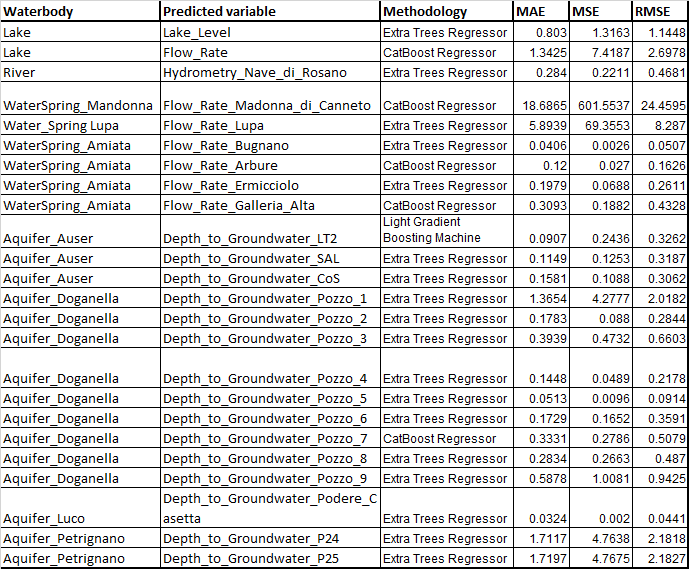